In [11]:
## run following in termminal (or in notebook) if needed to get packages to work
# !conda create -n tensorflow
# !source activate tensorflow
# !pip install jupyter notebook
# !jupyter-notebook
# !which pip
# !pip install tensorflow
# !pip install keras
# !pip install sklearn pandas numpy seaborn

## data split custom tool
from timeseries_train_test_split import TimeseriesTestTrainSplit as ts
##standard tools
import tensorflow
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
##preprocessing
from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler
## model selection and building
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score as r2
from sklearn.metrics import explained_variance_score as evs
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import median_absolute_error as mae
from keras.wrappers.scikit_learn import KerasRegressor
##models
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, Lasso, ElasticNet, LassoLars, BayesianRidge, ARDRegression, Perceptron, PassiveAggressiveRegressor, TheilSenRegressor, HuberRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, AdaBoostRegressor, StackingRegressor, VotingRegressor

In [3]:
# def run():
stock_name = 'GSIT'
X_train, y_train, X_test, y_test = ts.timeseries_test_train_split(stock_name)
print(X_test.shape)

(192, 60)


In [4]:
transformers = FeatureUnion([('scaler', MinMaxScaler()), ('norm', Normalizer())])
pipe = Pipeline([('preprocess', StandardScaler()), ('predictor', LinearRegression())])

In [5]:
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(13, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model 
def lstm_model():
    # create model
    model = Sequential()
    model.add(LSTM(13, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model 
keras_base = KerasRegressor(build_fn = baseline_model, nb_epoch=100, batch_size=5, verbose=1)
keras_lstm = KerasRegressor(build_fn = lstm_model, nb_epoch=100, batch_size=5, verbose=1)

In [6]:
lr_grid = {'predictor': [LinearRegression()]}
svr_grid = {
    'predictor': [SVR()],
    'predictor__kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}
d_tree_grid = {
    'predictor': [DecisionTreeRegressor()],
    'predictor__criterion': ['mse', 'friedman_mse', 'mae', 'poisson']  
}
mlp_grid = {
    'predictor': [MLPRegressor()],
    'predictor__learning_rate_init': [0.001],
    'predictor__random_state': [1],
    'predictor__max_iter': [400],
    'predictor__activation': ['relu','logistic'], ##'tanh',
    'predictor__hidden_layer_sizes': [(100,),(125,)], ## ,(50,)
    'predictor__alpha': [10**-x for x in range(1, 7)]
}
rfr_grid = {'predictor': [RandomForestRegressor()]  }
gbr_grid = {
    'predictor': [GradientBoostingRegressor()],
    'predictor__loss': ['ls', 'lad', 'huber', 'quantile']
}
etr_grid = {'predictor': [ExtraTreesRegressor()]}
abr_grid = {'predictor': [AdaBoostRegressor()]}
sgdr_grid = {'predictor': [SGDRegressor()]}
ridge_grid = {'predictor': [Ridge()]}
lasso_grid = {'predictor': [Lasso()]}
enet_grid = {'predictor': [ElasticNet()]}
lars_lasso_grid = {'predictor': [LassoLars()]}
br_grid = {'predictor': [BayesianRidge()]}
adrr_grid = {'predictor': [ARDRegression()]}
percep_grid = {'predictor': [Perceptron()]}
par_grid = {'predictor': [PassiveAggressiveRegressor()]}
tsr_grid = {'predictor': [TheilSenRegressor()]}
hbr_grid = {'predictor': [HuberRegressor()]}
keras_base_grid = {'predictor': [keras_base]}
keras_lstm_grid = {'predictor': [keras_lstm]}
param_grid = [
    {**lr_grid},
#     {**mlp_grid}, ##takes a long time
    {**svr_grid},
    {**d_tree_grid},
    {**rfr_grid},
    {**gbr_grid},
    {**etr_grid},
    {**abr_grid},
    {**sgdr_grid}, ##near competitor to linreg
    {**ridge_grid}, ##near competitor to linreg
    {**lasso_grid},
    {**enet_grid},
    {**lars_lasso_grid},
    {**br_grid},
    {**adrr_grid},
#     {**percep_grid}, ##not working
    {**par_grid},
    {**tsr_grid}, ##better than linear; and takes a while
    {**hbr_grid}
#     {**keras_base_grid}
#     {**keras_lstm_grid}
]

In [9]:
pipe.fit(X_train, y_train)
grid = GridSearchCV(pipe, param_grid, verbose=4, cv = 3, scoring='neg_median_absolute_error')
grid.fit(X_train, y_train)

Fitting 3 folds for each of 26 candidates, totalling 78 fits
[CV 1/3] END ...................predictor=LinearRegression(); total time=   0.0s
[CV 2/3] END ...................predictor=LinearRegression(); total time=   0.0s
[CV 3/3] END ...................predictor=LinearRegression(); total time=   0.0s
[CV 1/3] END ......predictor=SVR(), predictor__kernel=linear; total time=   0.4s
[CV 2/3] END ......predictor=SVR(), predictor__kernel=linear; total time=   0.2s
[CV 3/3] END ......predictor=SVR(), predictor__kernel=linear; total time=   0.2s
[CV 1/3] END ........predictor=SVR(), predictor__kernel=poly; total time=   0.0s
[CV 2/3] END ........predictor=SVR(), predictor__kernel=poly; total time=   0.1s
[CV 3/3] END ........predictor=SVR(), predictor__kernel=poly; total time=   0.0s
[CV 1/3] END .........predictor=SVR(), predictor__kernel=rbf; total time=   0.1s
[CV 2/3] END .........predictor=SVR(), predictor__kernel=rbf; total time=   0.0s
[CV 3/3] END .........predictor=SVR(), predictor

/Users/admin/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/admin/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/admin/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Inc

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocess', StandardScaler()),
                                       ('predictor', LinearRegression())]),
             param_grid=[{'predictor': [LinearRegression()]},
                         {'predictor': [SVR()],
                          'predictor__kernel': ['linear', 'poly', 'rbf',
                                                'sigmoid']},
                         {'predictor': [DecisionTreeRegressor()],
                          'predictor__criterion': ['mse', 'friedman_mse', 'mae',
                                                   'poisson']},
                         {'predictor': [...
                         {'predictor': [Ridge()]}, {'predictor': [Lasso()]},
                         {'predictor': [ElasticNet()]},
                         {'predictor': [LassoLars()]},
                         {'predictor': [BayesianRidge()]},
                         {'predictor': [ARDRegression()]},
                         {'

In [12]:

grid_est = grid.best_estimator_
y_pred = pipe.predict(X_test)
grid_pred = grid_est.predict(X_test)
grid.score(X_test, y_test)
print(grid.best_params_)
print('scores in ', grid.get_scorer(),' : grid', grid_est.score(X_test, y_test), 'linreg', pipe.score(X_test, y_test))
print(grid.scorer_)
print('median_absolute_error as mae;','explained_variance_score as evs;','mean_absolute_percentage_error as mape;')
print('linreg', mae(y_test, y_pred), evs(y_test, y_pred), mape(y_test, y_pred))
print('grid', mae(y_test, grid_pred), evs(y_test, grid_pred), mape(y_test, grid_pred))

{'predictor': ARDRegression()}
scores: grid 0.8547063255075268 linreg 0.8312687784824231
make_scorer(median_absolute_error, greater_is_better=False)
median_absolute_error as mae; explained_variance_score as evs; mean_absolute_percentage_error as mape;
linreg 0.16321497053729406 0.831299650615545 0.030350076971730505
grid 0.13398241397116628 0.8547364868568876 0.02794251308987165


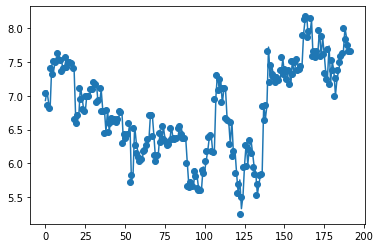

In [17]:
index = [i for i in range(len(y_test))]
plt.scatter(index, y_test)
plt.plot(index, grid_pred)


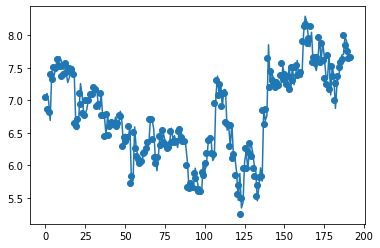

In [18]:
plt.scatter(index, y_test)
plt.plot(index, y_pred)